## 載入預訓練模型(Inception V3)

In [1]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input

# 建立一個輸入張量，指定圖像大小為224x224（RGB色彩通道）
input_tensor = Input(shape=(224, 224, 3))
# 建立 ResNet50 模型
model = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=True)

2023-10-13 21:24:35.954880: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-10-13 21:24:35.954917: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2023-10-13 21:24:35.955138: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input

# 載入圖像
image = tf.keras.utils.load_img('./dataset/cat_dog.jpg')
image = tf.keras.utils.img_to_array(image) # 將載入的圖像轉換為數組形式
x = np.expand_dims(image.copy(), axis=0) # 將圖像轉換為模型可接受的維度
# 預處理圖像
x = preprocess_input(x)

In [3]:
from tensorflow.keras.applications.resnet50 import decode_predictions

# 進行圖像分類預測
pred_proba = model.predict(x) # 返回分類機率
# 解析預測結果
pred_class_idx = pred_proba.argmax(axis=1)[0]  # 找到具有最高機率的類別索引
pred_class = decode_predictions(pred_proba, top=1)[0][0]  # 解析取得預測結果

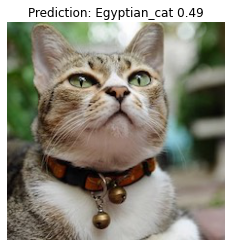

In [4]:
import matplotlib.pylab as plt

plt.imshow(image.astype('uint8'))
plt.axis('off')
predicted_class_name = pred_class[1]
_ = plt.title(f"Prediction: {predicted_class_name} {pred_class[2]:.2f}")

## Image-Specific Class Saliency 實作

In [5]:
def compute_gradients(image, target_class_idx):
    image = tf.convert_to_tensor(image)  # 將輸入的影像轉換為 TensorFlow 張量
    with tf.GradientTape() as tape:  # 用於計算梯度
        tape.watch(image)  # 監控圖像，以便計算其梯度
        predictions = model(image)  # 使用模型進行預測
        probs = predictions[:, target_class_idx]  # 取得目標類別的預測機率
    return tape.gradient(probs, image)  # 計算機率對於影像的梯度並返回

In [6]:
# 計算機率對於影像的梯度
gradients = compute_gradients(
    image=x,
    target_class_idx=pred_class_idx)
# 產生可解釋的遮罩
attribution_mask = tf.reduce_sum(tf.math.abs(tf.squeeze(gradients)), axis=-1)

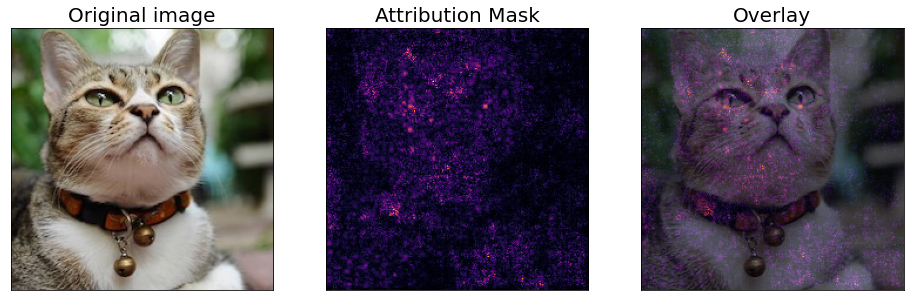

In [7]:
import matplotlib.cm as cm

fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 8),
                        subplot_kw={'xticks':[], 'yticks':[]})

axs[0, 0].set_title('Original image', fontsize=20)
axs[0, 0].imshow(image/255)

axs[0, 1].set_title('Attribution Mask', fontsize=20)
axs[0, 1].imshow(attribution_mask, cmap=cm.inferno)

axs[0, 2].set_title('Overlay', fontsize=20)
axs[0, 2].imshow(attribution_mask, cmap=cm.inferno)
axs[0, 2].imshow(image/255, alpha=0.4)